In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import shap
import warnings
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
ground_data = pd.read_csv(r'C:\Users\12045\Desktop\地块数据(预处理后).csv')
X = ground_data.drop(columns=['zcgdarea'])
y = ground_data['zcgdarea']

d:\Python3.11.7\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 方差选择法 
threshold = 0.5
selector_variance = VarianceThreshold(threshold=threshold)
X_selected_variance = selector_variance.fit_transform(X)
selected_features_variance = X.columns[selector_variance.get_support()]

# L1正则法
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
# 获取系数非零的特征
selected_features_lasso = X.columns[lasso.coef_ != 0]

# 互信息
from sklearn.feature_selection import mutual_info_regression
# 计算特征与目标变量的互信息
mi_scores = mutual_info_regression(X, y)
# 选择互信息得分较高的特征
selected_features_mi = X.columns[np.argsort(mi_scores)[-5:]]

# 随机森林
model_tree = RandomForestRegressor()
model_tree.fit(X, y)
# 获取特征重要性
feature_importances = model_tree.feature_importances_
# 选择重要性较高的特征
threshold_tree = 0.01  # 假设选择重要性大于0.01的特征
selected_features_tree = X.columns[feature_importances > threshold_tree]

# 相关系数法
# 这里以绝对值相关系数大于阈值作为特征选择标准
threshold_correlation = 0.5  # 设定阈值
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
selected_features_correlation = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold_correlation)]

# 将所有特征子集整合到一个集合中
all_feature_sets = []
all_feature_sets.extend(selected_features_variance)
all_feature_sets.extend(selected_features_tree)
all_feature_sets.extend(selected_features_lasso)
all_feature_sets.extend(selected_features_correlation)
all_feature_sets.extend(selected_features_mi)

# 计算每个特征子集的重叠次数
overlap_counts = {}
for feature_set in all_feature_sets:
    if feature_set in overlap_counts:
        overlap_counts[feature_set] += 1
    else:
        overlap_counts[feature_set] = 1

# 找到重叠次数大于等于1的特征子集
min_overlap_count = 1
selected_feature_sets = [feature_set for feature_set, count in overlap_counts.items() if count >= min_overlap_count]

print("重叠次数大于等于1的特征子集:")
for feature_set in selected_feature_sets:
    print(feature_set)
print("重叠次数:", min_overlap_count)


重叠次数大于等于1的特征子集:
hid
year
chengbaogd
chengbaogdks
jygdarea
jycbgdarea
jyczgdarea
jynhgdarea
jygdnum
jygdnum1
jygdnum5
zcqiyearea
zchezuoshearea
zccunjitiarea
zcnonghuarea
zcareahetong
zcareaqixian
jitizcarea
jitizcareacgb
zujin
cbdfangwei
zrdfangwei
cbdarea
zrdarea
cbdcwjuli
zrdcwjuli
cbddljuli
zrddljuli
zrdyear
zrdsyqixian
zrdhetong
zrdzuyue
d302a
d302b
d303a
d303b
d306a
d306b
d307a
d307b
d308a
d308b
d309b
d318a
d318b
d327a
d327b
d330a
d330b
d332a
d332b
c_chengbaogd
x_chengbaogd
s_chengbaogd
cychengbaogd
shifouzc
zrdgaosulu
zrdguangai
zrdfeili
zrdwrxiufu
zrdjyptreason2
d312b
d314a
d314b
d315b
d316b
d317a
d317b
d320a
d322a
d322b
d323a
d323b
d324a
d324b
d325a
d328b
d329b
d335b
重叠次数: 1


In [3]:
# 选取目标列和特征列，划分数据集

excluded_features = ['hid', 'year', 'chengbaogd', 'chengbaogdks', 'jygdarea', 'jycbgdarea', 'jyczgdarea',
                     'jynhgdarea', 'zcareahetong', 'zcareaqixian', 'jitizcarea', 'jitizcareacgb',
                     'cbdfangwei', 'zrdfangwei', 'cbdarea', 'zrdarea', 'c_chengbaogd', 'x_chengbaogd',
                     's_chengbaogd', 'cychengbaogd', 'shifouzc', 'zrdjyptreason2','zcqiyearea',
                     'zchezuoshearea','zcwainonghuarea','zcgdksnum','zccunjitiarea','zcnonghuarea']

X = ground_data[selected_feature_sets].drop(columns=excluded_features, errors='ignore')

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# 线性回归

# 初始化线性回归模型
model = LinearRegression()
# 在训练集上训练模型
model.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = model.predict(X_test)

# 输出模型的系数
coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': model.coef_})
print("\nCoefficients:\n", coefficients)

# 计算各项指标
print('\n线性回归模型各项指标:')
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


Coefficients:
        Variable  Coefficient
0       jygdnum    -0.000043
1      jygdnum1    -0.001372
2      jygdnum5     0.000058
3         zujin     0.246884
4     cbdcwjuli     0.033312
5     zrdcwjuli    -0.022489
6     cbddljuli    -0.018131
7     zrddljuli    -0.039866
8       zrdyear    -0.032698
9   zrdsyqixian     0.095098
10    zrdhetong     0.000070
11     zrdzuyue    -0.011872
12        d302a     0.014295
13        d302b     0.034174
14        d303a     0.041682
15        d303b    -0.043077
16        d306a    -0.037670
17        d306b     0.004277
18        d307a    -0.064449
19        d307b     0.053792
20        d308a     0.079729
21        d308b    -0.067900
22        d309b     0.018973
23        d318a     0.018318
24        d318b    -0.003011
25        d327a     0.253799
26        d327b    -0.286273
27        d330a     0.072218
28        d330b    -0.080373
29        d332a    -0.055081
30        d332b     0.012309
31   zrdgaosulu    -0.070049
32   zrdguangai     0.07726

In [5]:
# 随机森林

# 初始化随机森林模型
rf_model = RandomForestRegressor(random_state=42)

# 定义超参数搜索空间(模型将自动选取最好的那一组参数值)
param_grid = {
    'n_estimators': [50, 100, 200],  # 树的数量
    'max_depth': [5, 10, 20],  # 树的最大深度
    'min_samples_split': [2, 5, 10]  # 最小分裂样本数
}

# 初始化网格搜索
print("正在使用网格搜索寻找模型最佳参数...")
# estimator:优化的模型  param_grid:超参数空间   cv:交叉验证的折数  scoring:评估指标（此处用的是负均方误差）  verbose: 设为1表示输出进度
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# 在训练集上进行网格搜索 对每一种超参数组合进行交叉验证，并选择在验证集上性能最好的模型
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("最佳参数:", best_params)

# 使用最佳参数的模型进行预测
best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)

print("\n随机森林模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2, '\n')

正在使用网格搜索寻找模型最佳参数...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
最佳参数: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

随机森林模型各项误差指标
均方误差（MSE）: 0.35409802806236995
平均绝对误差（MAE）: 0.2972443377326358
R-squared: 0.6911018929268387 



In [6]:
# XGBoost(极限梯度提升)

# 定义超参数搜索空间(模型将自动选取最好的那一组参数值)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 8]
}

# 初始化XGBoost回归模型
xgb_regressor = xgb.XGBRegressor()

# 使用网格搜索进行参数调优
print("正在使用网格搜索寻找模型最佳参数...")
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 输出最佳参数组合和对应的性能指标
print("最佳参数:", grid_search.best_params_)

# 获取经过参数调优后的最佳模型
best_model = grid_search.best_estimator_

# 使用最佳模型进行预测
y_pred = best_model.predict(X_test)

print("\nXGBoost模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


正在使用网格搜索寻找模型最佳参数...
最佳参数: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

XGBoost模型各项误差指标
均方误差（MSE）: 0.3097736759664161
平均绝对误差（MAE）: 0.28550436245889227
R-squared: 0.7297683281357714


In [7]:
# 决策树

tree_model = DecisionTreeRegressor(random_state=43)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

print("\n决策树模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2, '\n')


决策树模型各项误差指标
均方误差（MSE）: 0.5764554306319961
平均绝对误差（MAE）: 0.3474897270937951
R-squared: 0.4971279780668433 



XGBOOST模型

In [8]:
# XGBoost(极限梯度提升)

# 定义超参数搜索空间(模型将自动选取最好的那一组参数值)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 8]
}

# 初始化XGBoost回归模型
xgb_regressor = xgb.XGBRegressor()

# 使用网格搜索进行参数调优
print("正在使用网格搜索寻找模型最佳参数...")
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 输出最佳参数组合和对应的性能指标
print("最佳参数:", grid_search.best_params_)

# 获取经过参数调优后的最佳模型
best_model = grid_search.best_estimator_

# 使用最佳模型进行预测
y_pred = best_model.predict(X_test)
# 计算各特征SHAP值(随机森林模型训练和预测中间)
# 创建 TreeExplainer 解释器（用于树模型）
explainer = shap.TreeExplainer(best_rf_model)
# 计算 SHAP 值
shap_values = explainer.shap_values(X)
shap_values2 = explainer(X)
# 计算特征重要性
shap_importance = np.abs(shap_values).mean(0)
shap_importance_df = pd.DataFrame(shap_importance, index=X_train.columns, columns=["SHAP Importance"])
shap_importance_df = shap_importance_df.sort_values(by="SHAP Importance", ascending=False)
print("\n各特征SHAP值(随机森林模型):\n", shap_importance_df)

正在使用网格搜索寻找模型最佳参数...
最佳参数: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

各特征SHAP值(随机森林模型):
              SHAP Importance
zujin               0.603138
jygdnum             0.082519
cbddljuli           0.043043
zrdyear             0.032759
zrdhetong           0.032249
d307b               0.019988
d330b               0.016066
zrddljuli           0.014879
zrdcwjuli           0.014872
d307a               0.011332
cbdcwjuli           0.009598
d308b               0.008541
jygdnum1            0.007247
zrdsyqixian         0.007112
jygdnum5            0.006676
zrdguangai          0.005886
d332b               0.004872
d327b               0.004756
d332a               0.004381
zrdgaosulu          0.004251
zrdzuyue            0.003756
d309b               0.003152
d329b               0.003109
d327a               0.002883
zrdfeili            0.002678
d308a               0.002485
d306a               0.002007
d303b               0.001733
d318b               0.001633
d302a               0.00

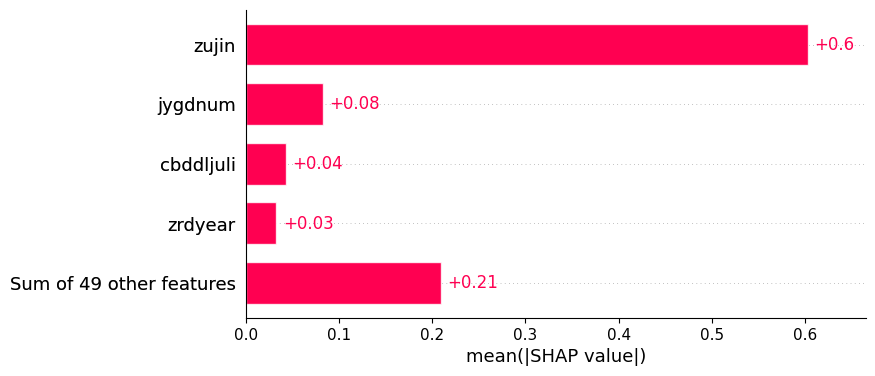

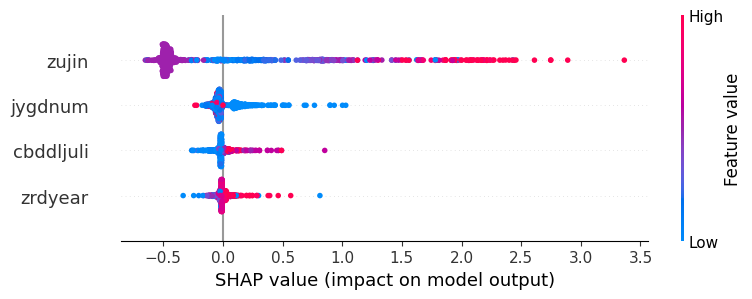

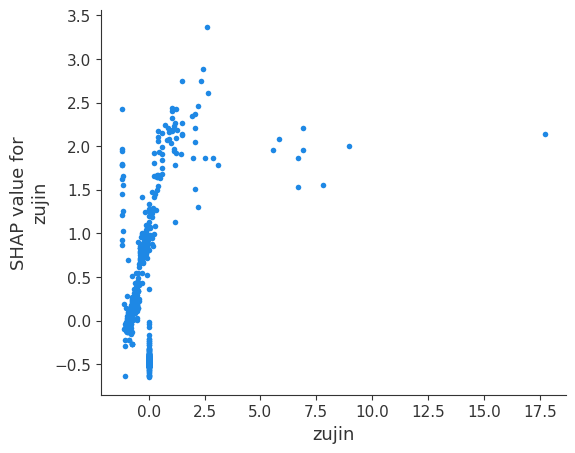

In [11]:
# 可视化 SHAP 值
# 柱状图
shap.plots.bar(shap_values2, max_display=5)

# 散点分布图
shap.summary_plot(shap_values, X, max_display=4)

# SHAP值最大的特征的shap值演变
shap.dependence_plot('zujin', shap_values, X, interaction_index=None)
